In [13]:
# === Standard Library ===
import math
import random
import time
import heapq
import itertools
from collections import defaultdict, deque
from itertools import combinations
from typing import Any, Tuple, Dict, List, Set, Sequence, Union
from itertools import permutations, combinations

# === Third-Party Libraries ===

# --- Scientific Computing ---
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.optimize import linprog

# --- Plotting ---
import matplotlib.pyplot as plt

# --- Parallel Processing ---
from joblib import Parallel, delayed
from tqdm import tqdm

# --- Graph Processing ---
import networkx as nx

# --- JIT Compilation ---
from numba import njit, prange

- Detailed and one-by-one experiments with REGA implementation

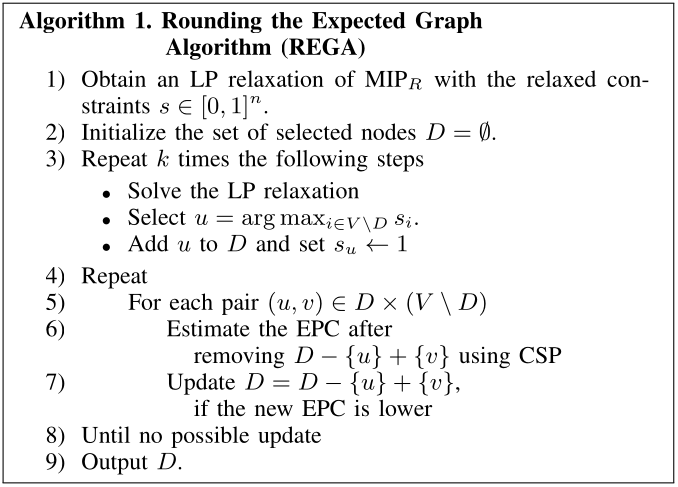

# 1. Experiments with Mixed Linear Programming Part

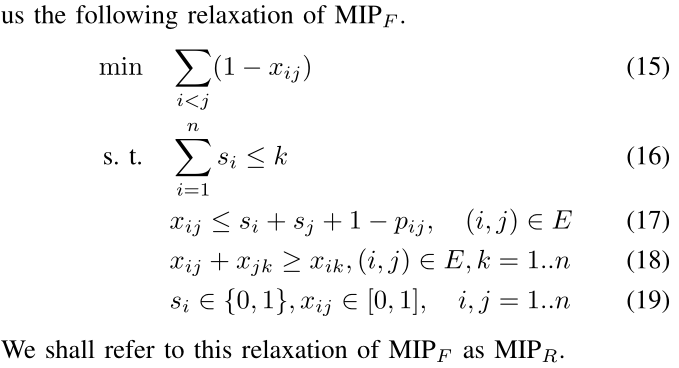

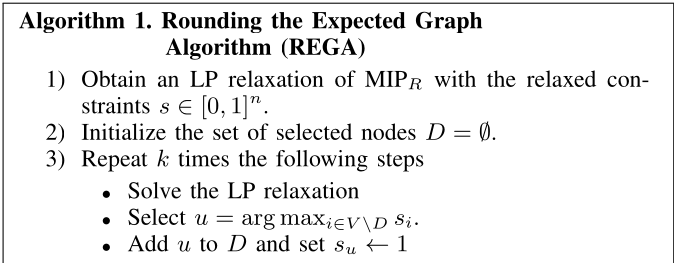

In [4]:
nodes = [1, 2, 3, 4]

edges = [
    (1, 2, 0.8),
    (1, 3, 0.5),
    (1, 4, 0.3),
    (2, 3, 0.9),
    (2, 4, 0.4),
    (3, 4, 0.7),
]

# budget
k = 1

In [5]:
# building LP
n = len(nodes)
edge_pairs = [(u, v) for u, v, _ in edges]
p = { (u, v): prob for u, v, prob in edges } | { (v, u): prob for u, v, prob in edges }

num_s = n
num_x = len(edge_pairs)
num_vars = num_s + num_x

c = [0.0] * num_s + [-1.0] * num_x  

A_ub = []
b_ub = []

# budget constraint  
A_ub.append([1.0] * num_s + [0.0] * num_x)
b_ub.append(k)

# edge constraints
for idx, (i, j) in enumerate(edge_pairs):
    row = [0.0] * num_vars
    row[i - 1] = -1.0
    row[j - 1] = -1.0
    row[num_s + idx] = 1.0
    A_ub.append(row)
    b_ub.append(1 - p[(i, j)])

# triangle constraints
for i, j, k_ in itertools.permutations(nodes, 3):
    if (i, j) not in p or (j, k_) not in p or (i, k_) not in p:
        continue
    row = [0.0] * num_vars
    # indices of the x variables in compact order
    def x_index(u, v):
        pair = (u, v) if (u, v) in edge_pairs else (v, u)
        return num_s + edge_pairs.index(pair)
    row[x_index(i, k_)] = 1.0
    row[x_index(i, j)] = -1.0
    row[x_index(j, k_)] = -1.0
    A_ub.append(row)
    b_ub.append(0.0)

In [6]:
# variable bounds 
bounds = [(0, 1)] * num_vars

res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")

var_names = [f"s_{i}" for i in nodes] + [f"x_{u}{v}" for (u, v) in edge_pairs]
solution_df = pd.DataFrame({"variable": var_names, "value": res.x.round(3)})

sum_x = res.x[num_s:].sum()
original_obj = len(edge_pairs) - sum_x

print(f"Optimal value = {original_obj:.3f}")

Optimal value = 0.700


## Sanity Check

In [7]:
nodes = [1, 2, 3]
p = { 
  (1,2):0.8, 
  (1,3):0.2, 
  (2,3):0.2 
  }

# edge undirected
p.update({(j,i):v for (i,j),v in p.items()})

k = 1  # deletion budget

var_names = ["s1","s2","s3","x12","x13","x23"]
num_s = 3
num_x = 3
num_vars = num_s + num_x

c = [0,0,0] + [-1,-1,-1]

A_ub = []
b_ub = []

# budget constraint
A_ub.append([1,1,1,0,0,0])
b_ub.append(k)

# edge constraints
edge_indices = {(1,2):3,(1,3):4,(2,3):5}

def add_edge_constraint(i,j,prob):
    row = [0]*num_vars
    row[i-1] = -1
    row[j-1] = -1
    row[edge_indices[(i,j)]] = 1
    A_ub.append(row)
    b_ub.append(1 - prob)

for (i,j),prob in {(1,2):0.8,(1,3):0.2,(2,3):0.2}.items():
    add_edge_constraint(i,j,prob)

# triangle constraints
def tri(i,j,k):
    row = [0]*num_vars
    row[edge_indices[tuple(sorted((i,k)))]] = 1
    row[edge_indices[tuple(sorted((i,j)))]] = -1
    row[edge_indices[tuple(sorted((j,k)))]] = -1
    A_ub.append(row); b_ub.append(0)

tri(1,2,3)
tri(1,3,2)
tri(2,3,1)

bounds = [(0,1)]*num_vars

# solve LP
res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")

sol_df = pd.DataFrame({"variable":var_names,"value":np.round(res.x,3)})

sum_x = res.x[num_s:].sum()
original_obj = 3 - sum_x
print(f"LP optimal = {original_obj:.3f}")

LP optimal = 0.000


In [8]:

def solve_with_fixed_s(s_fixed):
    
    bnd = []
    for idx,val in enumerate(s_fixed):
        bnd.append( (val,val) )

    bnd += [(0,1)]*num_x
    r = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bnd, method="highs")

    return 3 - r.x[num_s:].sum()

enum_results = []
for s in itertools.product([0,1], repeat=3):
    if sum(s)<=k:
        obj = solve_with_fixed_s(s)
        enum_results.append({"s":s, "objective":obj})

enum_df = pd.DataFrame(enum_results).sort_values("objective")
enum_df

,s,objective
3,"(1, 0, 0)",0.2
2,"(0, 1, 0)",0.2
1,"(0, 0, 1)",0.8
0,"(0, 0, 0)",1.2


In [12]:
p = {(1,2):0.8,(1,3):0.2,(2,3):0.2}

best = float('inf')
best_s = None
for s1 in (0,1):
  for s2 in (0,1):
    for s3 in (0,1):
      if s1+s2+s3>1: continue
      
      rem = []
      if s1==0 and s2==0: rem.append((1,2))
      if s1==0 and s3==0: rem.append((1,3))
      if s2==0 and s3==0: rem.append((2,3))
      obj = sum(1-p[e] for e in rem)
      if obj<best:
        best, best_s = obj, (s1,s2,s3)

print("Best integral objective:", best)
print("Delete pattern s:", best_s)

Best integral objective: 0.19999999999999996
Delete pattern s: (0, 0, 1)


# 2. REGA implementation

## 2.1 Component EPC (non-parallel)

In [9]:
def component_sampling_epc_mc(G, S, num_samples=10_000,
                              epsilon=None, delta=None, use_tqdm=False):
  """
  Theoretic bounds: compute N = N(epsilon, delta) by the theoretical bound.
  Experimentation:  Otherwise, use the N as input for sample count.
  """

  # Surviving vertex set and its size
  V_remaining = set(G.nodes()) - S
  n_rem = len(V_remaining)

  # base case
  if n_rem < 2:
    return 0.0

  if num_samples is None:
    assert epsilon is not None and delta is not None
    P_E = sum(G.edges[u, v]['p'] for u, v in G.edges())
    coeff = 4 * (math.e - 2) * math.log(2 / delta)
    num_samples = math.ceil(coeff * n_rem * (n_rem - 1) /
                            (epsilon ** 2 * P_E))

  C2 = 0
  it = tqdm(range(num_samples), desc='Component sampling',
            total=num_samples) if use_tqdm else range(num_samples)

  for _ in it:
    u = random.choice(tuple(V_remaining))

    # BFS based on edge probabilities

    visited = {u}
    queue = [u]

    while queue:

      v = queue.pop()
      for w in G.neighbors(v):

        # flip a coin biased by the edge probability
        # w not in deleted nodes
        if w in V_remaining and random.random() < G.edges[v, w]['p']:

          # if w is not visited
          if w not in visited:
              visited.add(w)
              queue.append(w)

    # component counting
    C2 += (len(visited) - 1)

  return (n_rem * C2) / (2 * num_samples)

## 2.2 EPC (parallelized)

In [11]:
def nx_to_csr(G: nx.Graph) -> Tuple[List[int], Dict[int, int], np.ndarray, np.ndarray, np.ndarray]:
     """Convert an undirected NetworkX graph (edge attr `'p'`) to CSR arrays."""
     nodes: List[int] = list(G.nodes())
     idx_of: Dict[int, int] = {u: i for i, u in enumerate(nodes)}

     indptr: List[int] = [0]
     indices: List[int] = []
     probs: List[float] = []

     for u in nodes:
         for v in G.neighbors(u):
             indices.append(idx_of[v])
             probs.append(G.edges[u, v]['p'])
         indptr.append(len(indices))

     return (
         nodes,
         idx_of,
         np.asarray(indptr, dtype=np.int32),
         np.asarray(indices, dtype=np.int32),
         np.asarray(probs, dtype=np.float32),
     )

@njit(inline="always")
def _bfs_component_size(start: int,
                    indptr: np.ndarray,
                    indices: np.ndarray,
                    probs: np.ndarray,
                    deleted: np.ndarray) -> int:
    """Return |C_u|−1 for **one** random realisation (stack BFS)."""
    n = deleted.size
    stack = np.empty(n, dtype=np.int32)
    visited = np.zeros(n, dtype=np.uint8)

    size = 1
    top = 0
    stack[top] = start
    top += 1
    visited[start] = 1

    while top:
        top -= 1
        v = stack[top]
        for eid in range(indptr[v], indptr[v + 1]):
            w = indices[eid]
            if deleted[w]:
                continue
            if np.random.random() >= probs[eid]:
                continue
            if visited[w]:
                continue
            visited[w] = 1
            stack[top] = w
            top += 1
            size += 1
    return size - 1

@njit(parallel=True)
def epc_mc(indptr: np.ndarray,
            indices: np.ndarray,
            probs: np.ndarray,
            deleted: np.ndarray,
            num_samples: int) -> float:
    """Monte‑Carlo estimator of **expected pairwise connectivity** (EPC)."""
    surv = np.where(~deleted)[0]
    m = surv.size
    if m < 2:
        return 0.0

    acc = 0.0
    for _ in prange(num_samples):
        u = surv[np.random.randint(m)]
        acc += _bfs_component_size(u, indptr, indices, probs, deleted)

    return (m * acc) / (2.0 * num_samples)

def epc_mc_deleted(
  G: nx.Graph,
  S: set,
  num_samples: int = 100_000,
) -> float:
  # build csr once
  nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
  n = len(nodes)

  # turn python set S into a mask (node-IDs to delete)
  deleted = np.zeros(n, dtype=np.bool_)
  for u in S:
    deleted[idx_of[u]] = True

  epc = epc_mc(indptr, indices, probs, deleted, num_samples)

  return epc

## 2.3 REGA

In [31]:
def solve_lp_relaxation(G: nx.Graph, pre_fixed: set, k: int):
    V = list(G.nodes())
    # build x for every possible pair, not just the edges
    Pairs = [tuple(sorted((u, v))) for u, v in combinations(V, 2)]
    n, m = len(V), len(Pairs)

    s_idx = {v: i for i, v in enumerate(V)}
    x_idx = {e: n + j for j, e in enumerate(Pairs)}
    N = n + m

    # bounds
    bounds = [(0, 1)] * N
    for v in pre_fixed:
        bounds[s_idx[v]] = (1, 1)

    # objective: min sum(1 - x)
    c = np.zeros(N)
    for e in Pairs:
        c[x_idx[e]] = -1.0

    A_ub, b_ub = [], []

    # budget sum s <= k
    row = np.zeros(N); row[:n] = 1
    A_ub.append(row); b_ub.append(k)

    # edge upper   x_uv - s_u - s_v <= 1 - p_uv 
    for (u, v) in Pairs:
        p_uv = G.edges[u, v]["p"] if G.has_edge(u, v) else 0.0
        row = np.zeros(N)
        row[x_idx[(u, v)]] = 1
        row[s_idx[u]]          = -1
        row[s_idx[v]]          = -1
        A_ub.append(row)
        b_ub.append(1 - p_uv)

    # triangle x_ik - x_ij - x_jk <= 0  for all i,j,k distinct
    for i, j, k in permutations(V, 3):
        if i < k:
            row = np.zeros(N)
            row[x_idx[tuple(sorted((i, k)))]] =  1
            row[x_idx[tuple(sorted((i, j)))]] = -1
            row[x_idx[tuple(sorted((j, k)))]] = -1
            A_ub.append(row)
            b_ub.append(0)

    A_ub = np.vstack(A_ub)
    b_ub = np.array(b_ub)

    res = linprog(c,
                  A_ub=A_ub, b_ub=b_ub,
                  bounds=bounds,
                  method="highs")
    if not res.success:
        raise RuntimeError(res.message)

    s_vals = {v: res.x[s_idx[v]] for v in V}
    x_sum  = res.x[n:].sum()
    
    obj    = len(Pairs) - x_sum 

    return s_vals, obj

def rega(G: nx.Graph,
        k: int,
        epc_func,
        num_samples: int = 10_000,
        # epsilon: float = None,
        # delta: float = None,
        use_tqdm: bool = False):
    """
    Full REGA pipeline: LP‐rounding + CSP‐refined local swaps.
    """

    # iterative rounding
    D = set()
    for _ in range(k):
        s_vals, _ = solve_lp_relaxation(G, pre_fixed=D, k=k)
        # pick the fractional s_i largest among V\D
        u = max((v for v in G.nodes() if v not in D),
                key=lambda v: s_vals[v])
        D.add(u)

    # local‐swap refinement
    current_epc = epc_func(G, D,
                           num_samples=num_samples,
                        #    epsilon=epsilon,
                        #    delta=delta,
                        #    use_tqdm=use_tqdm
                           )

    improved = True
    
    while improved:

        improved = False
        best_epc = current_epc
        best_swap = None

        for u in list(D):
            for v in G.nodes():

                if v in D: 
                    continue

                D_new = (D - {u}) | {v}

                epc_val = epc_func(G, D_new,
                                   num_samples=num_samples,
                                #    epsilon=epsilon,
                                #    delta=delta,
                                #    use_tqdm=use_tqdm
                                   )
                
                if epc_val < best_epc:
                    best_epc = epc_val
                    best_swap = (u, v)

        if best_swap is not None:

            u, v = best_swap
            D.remove(u)
            D.add(v)
            current_epc = best_epc
            improved = True

    return D

### Greedy-ES, Greedy-MIS implementations

In [15]:
def greedy_cndp_epc_celf(
    G: nx.Graph,
    K: int,
    *,
    num_samples: int = 20_000,
    reuse_csr: Tuple = None,
    return_trace: bool = False,
) -> Union[Set[int], Tuple[Set[int], List[float]]]:
    """Select **K** nodes that minimise EPC using CELF & Numba.

    Parameters
    ----------
    return_trace : bool, default *False*
        If *True*, also return a list `[σ(S₁), σ(S₂), …]` where `S_i` is the
        prefix after deleting *i* nodes.  Useful for plots.
    """

    # CSR cache --------------------------------------------------------
    if reuse_csr is None:
        nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
    else:
        nodes, idx_of, indptr, indices, probs = reuse_csr
    n = len(nodes)

    deleted = np.zeros(n, dtype=np.bool_)
    current_sigma = epc_mc(indptr, indices, probs, deleted, num_samples)

    pq: List[Tuple[float, int, int]] = []  # (-gain, v, last_round)
    gains = np.empty(n, dtype=np.float32)

    for v in range(n):
        deleted[v] = True
        gains[v] = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
        deleted[v] = False
        heapq.heappush(pq, (-gains[v], v, 0))

    S: Set[int] = set()
    trace: List[float] = []
    round_ = 0

    trace.append(current_sigma)

    while len(S) < K and pq:
        neg_gain, v, last = heapq.heappop(pq)
        if last == round_:
            # gain up‑to‑date → accept
            S.add(nodes[v])
            deleted[v] = True
            current_sigma += neg_gain  # add neg (= subtract gain)
            round_ += 1
            if return_trace:
                trace.append(current_sigma)
        else:
            # recompute gain lazily
            deleted[v] = True
            new_gain = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
            deleted[v] = False
            heapq.heappush(pq, (-new_gain, v, round_))

    return (S, trace) if return_trace else S

def optimise_epc(
     G: nx.Graph,
     K: int,
     *,
     num_samples: int = 20_000,
     return_trace: bool = False,
 ) -> Union[Set[int], Tuple[Set[int], List[float]]]:
     csr = nx_to_csr(G)
     return greedy_cndp_epc_celf(G, K, num_samples=num_samples, reuse_csr=csr, return_trace=return_trace)

def local_search_swap(
  # G: nx.Graph,
  S: Set[int],
  *,
  csr: Tuple[List[int], Dict[int,int], np.ndarray, np.ndarray, np.ndarray],
  num_samples: int = 100_000,
  max_iter: int = 5
) -> Set[int]:
  """
  Given initial delete-set S, try 1-for-1 swaps to reduce EPC.
  csr = (nodes, idx_of, indptr, indices, probs).
  """
  nodes, idx_of, indptr, indices, probs = csr
  n = len(nodes)

  # build boolean mask from S
  deleted = np.zeros(n, dtype=np.bool_)
  for u in S:
    deleted[idx_of[u]] = True

  # current EPC
  curr = epc_mc(indptr, indices, probs, deleted, num_samples)

  for it in range(max_iter):
    best_delta = 0.0
    best_swap = None

    # try swapping each i in S with each j not in S
    for i in list(S):
      ii = idx_of[i]
      # undelete i
      deleted[ii] = False

      for j in nodes:
        jj = idx_of[j]
        if deleted[jj]:
          continue
        # delete j
        deleted[jj] = True

        sigma = epc_mc(indptr, indices, probs, deleted, num_samples)
        delta = curr - sigma
        if delta > best_delta:
          best_delta = delta
          best_swap = (ii, jj, sigma)

        # revert j
        deleted[jj] = False

      # revert i

      deleted[ii] = True

    if best_swap is None:
      break   

    # commit the best swap
    ii, jj, new_sigma = best_swap
    deleted[ii] = False
    deleted[jj] = True
    curr = new_sigma

    # update S
    S.remove(nodes[ii])
    S.add(nodes[jj])

  return S

def greedy_es_local_opt(
    G, K,
    num_samples=100_000, local_iter=5, return_trace=True
):
  t0 = time.perf_counter()
  G_greedy_es, sigma_delta = optimise_epc(
    G=G, K=K, num_samples=num_samples, return_trace=return_trace)
  t_greedy_es = time.perf_counter() - t0

  # epc_greedy_es = component_sampling_epc_mc(G_greedy_es, set(), N_SAMPLE)
  epc_greedy_es = sigma_delta[-1]

  csr = nx_to_csr(G)

  S_opt = local_search_swap(
    G_greedy_es, csr=csr, 
    num_samples=num_samples, max_iter=local_iter)

  epc_final = epc_mc_deleted(G, S_opt, num_samples)

  return t_greedy_es, epc_greedy_es, epc_final

In [34]:
def greedy_epc_mis(G, k, num_samples):

  # Maximal independent set
  MIS = nx.maximal_independent_set(G)
  R = set(MIS)
  target = len(G) - k
  V = G.number_of_nodes()

  sigma_delta = []

  # print(f"#MIS: {len(R)}")

  # Greedy grow R set until |R| = |V| - k
  while len(R) < target:
    best_j, best_sigma = None, float('inf')
    for j in G.nodes():
      if j in R:
        continue

      # delete node
      S_j = set(G.nodes()) - (R | {j})
      sigma = component_sampling_epc_mc(G, S=S_j, num_samples=num_samples)

      if sigma < best_sigma:
        best_sigma, best_j = sigma, j

        sigma_delta.append(best_sigma)

    R.add(best_j)
  
  D = set(G.nodes()) - R
  return D, sigma_delta

@njit
def greedy_epc_mis_numba(
    indptr: np.ndarray,
    indices: np.ndarray,
    probs: np.ndarray,
    deleted: np.ndarray,
    n: int,
    k: int,
    num_samples: int,
) -> Tuple[np.ndarray, np.ndarray, int]:
    target_survivors = n - k
    survivors = n - np.sum(deleted)

    flips_needed = target_survivors - survivors
    if flips_needed < 0:
        flips_needed = 0

    max_steps = 1 + flips_needed
    trace_np = np.empty(max_steps, dtype=np.float64)

    step = 0
    curr_epc = epc_mc(indptr, indices, probs, deleted, num_samples)
    trace_np[step] = curr_epc
    step += 1

    while survivors < target_survivors:
        best_sigma = 1e18
        best_j = -1

        for j in range(n):
            if deleted[j]:
                deleted[j] = False
                sigma = epc_mc(indptr, indices, probs, deleted, num_samples)
                deleted[j] = True
                if sigma < best_sigma:
                    best_sigma = sigma
                    best_j = j

        deleted[best_j] = False
        survivors += 1
        curr_epc = best_sigma

        trace_np[step] = curr_epc
        step += 1
    return deleted, trace_np, step

def greedy_mis_optimized(
  G: nx.Graph,
  k: int,
  *,
  num_samples: int = 100_000,
  return_trace: bool = False,
) -> Union[Set[int], Tuple[Set[int], list]]:
    
    # CSR conversion
    nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
    n = len(nodes)

    # 2. Build initial MIS mask
    # MIS = nx.maximal_independent_set(G)
    # deleted = np.ones(n, dtype=np.bool_)
    # for u in MIS:
    #     deleted[idx_of[u]] = False

    # best_deleted: np.ndarray = None
    # best_sigma = float("inf")

    # for i in range(mis_rounds):
    #     MIS = nx.maximal_independent_set(G)

    #     # deleted[i]==True means node i is removed
    #     deleted = np.ones(n, dtype=np.bool_)
        
    #     for u in MIS:
    #         deleted[idx_of[u]] = False
        
    #     curr_sigma = epc_mc(indptr, indices, probs, deleted, num_samples)

    #     # print(f"{i}-th rount sigma: {curr_sigma}")

    #     if curr_sigma < best_sigma:
    #         best_sigma = curr_sigma
    #         best_deleted = deleted.copy()

    MIS = nx.algorithms.approximation.maximum_independent_set(G)

    deleted = np.ones(n, dtype=np.bool_)
    for u in MIS:
        deleted[idx_of[u]] = False

    best_deleted = deleted.copy()

    # Call the fast Numba core
    final_deleted, trace_np, cnt = greedy_epc_mis_numba(
        indptr, indices, probs, 
        best_deleted, 
        n, k, num_samples
    )

    # Slice out only the filled portion of the trace
    trace = trace_np[:cnt].tolist()

    # Map mask back to node-IDs
    D = {nodes[i] for i in range(n) if final_deleted[i]}

    return (D, trace) if return_trace else D

def greedy_mis_local_search(
    G: nx.Graph,
    k: int,
    *,
    num_samples: int = 100_000,
    max_local_iters: int = 5
) -> Set[int]:
    # build CSR
    nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
    n = len(nodes)

    # get a starting D via your Numba‐greedy MIS
    S = greedy_mis_optimized(
        G, k, 
        num_samples=num_samples, mis_rounds=100,
        return_trace=False)
    
    # make the Boolean mask
    deleted = np.zeros(n, dtype=np.bool_)
    for u in S:
        deleted[idx_of[u]] = True

    # run the local search
    final_deleted = local_search_swap(
        indptr, indices, probs, 
        deleted, n, num_samples, max_local_iters
    )

    # map back to node IDs
    return {nodes[i] for i in range(n) if final_deleted[i]}

def robust_greedy_mis_optimized(
  G, k, 
  num_samples=100_000, trials=10, 
  max_iter=10, use_tqdm=False):
  # best_D, best_epc = None, float('inf')
  csr = nx_to_csr(G)
  epcs_initial = []
  epcs = []
  time_initial = []

  if use_tqdm:
    it = tqdm(range(trials), desc="Processing MIS-greedy", total=trials)
  else:
    it = range(trials)
  
  for _ in it:
    
    t0 = time.perf_counter()

    S = greedy_mis_optimized(
      G, k,
      num_samples=num_samples,
      return_trace=False)
    
    epc_initial = epc_mc_deleted(G, S, num_samples)
    epcs_initial.append(epc_initial)
    t_greedy_mis_initial = time.perf_counter() - t0

    time_initial.append(t_greedy_mis_initial)

    S_opt = local_search_swap(
      S, csr=csr, num_samples=num_samples, max_iter=max_iter)
    
    epc_final = epc_mc_deleted(G, S_opt, num_samples)
    epcs.append(epc_final)

    # epc_final = component_sampling_epc_mc(G, S_opt, num_samples)
    # epcs.append(epc_final)

  mean_epc_initial = sum(epcs_initial) / trials
  std_epc_initial = (sum((e - mean_epc_initial)**2 for e in epcs_initial) / trials)**0.5

  mean_epc = sum(epcs) / trials
  std_epc = (sum((e - mean_epc)**2 for e in epcs) / trials)**0.5

  time_initial_final = sum(time_initial) / trials

  return time_initial_final, mean_epc_initial, std_epc_initial, mean_epc, std_epc

### Sanity checking with Greedy-ES, Greedy-MIS

In [27]:
G = nx.Graph()
G.add_edge(1, 2, p=0.8)
G.add_edge(1, 3, p=0.2)
G.add_edge(2, 3, p=0.2)

# run REGA
D = rega(G,
          k=1,
          epc_func=component_sampling_epc_mc,
          num_samples=100_000,
          use_tqdm=False)

print("Selected nodes to delete:", D)
print("Estimated EPC after removal:", 
      component_sampling_epc_mc(G, D, num_samples=100_000))

Selected nodes to delete: {2}
Estimated EPC after removal: 0.20027


In [35]:
SEED = 42
N_SAMPLE = 100_000
LOCAL_ITER = 5

K = 3
NODES = 30
# nodes 100, edges 200 (Sparse Graphs)
graph_models = {
  'ER': nx.erdos_renyi_graph(NODES, 0.0443, seed=SEED),
  'BA': nx.barabasi_albert_graph(NODES, 2,seed=SEED),
  'SW': nx.watts_strogatz_graph(NODES, 4, 0.3, seed=SEED)
}

In [36]:
graph_models = {
  'ER': nx.erdos_renyi_graph(NODES, 0.0443, seed=SEED),
  'BA': nx.barabasi_albert_graph(NODES, 2,seed=SEED),
  'SW': nx.watts_strogatz_graph(NODES, 4, 0.3, seed=SEED)
}

In [ ]:
records = []

for name_model, G in tqdm(
  graph_models.items(), 
  desc="Processing models", 
  total=len(graph_models)):

  for p in tqdm(np.arange(0.0, 1.1, 0.1), desc="Processing", total=int(1.1/0.1)):

    def fresh_graph():
      H = G.copy()
      for u, v in H.edges():
        H[u][v]['p'] = p
      return H

    # greedy ES local
    t0 = time.perf_counter()

    t_greedy_es_initial, initial_epc_greedy_es, final_epc_greedy_es = greedy_es_local_opt(
      fresh_graph(), K, num_samples=N_SAMPLE,
      local_iter=LOCAL_ITER, return_trace=True)
    
    t_greedy_es_final = time.perf_counter() - t0

    # greedy MIS local
    t0 = time.perf_counter()

    t_greedy_mis_initial, mis_epc_initial, mis_epc_init_std, mis_epc_final, mis_epc_final_std = robust_greedy_mis_optimized(
      fresh_graph(), K, num_samples=N_SAMPLE,
      trials=10, max_iter=LOCAL_ITER)
    t_greedy_mis_final = time.perf_counter() - t0
    
    # REGA
    t0 = time.perf_counter()

    rega_D = rega(
      fresh_graph(),
      k=K,
      epc_func=epc_mc_deleted,
      num_samples=100_000,
      use_tqdm=False)
    
    rega_epc = epc_mc_deleted(fresh_graph(), rega_D, N_SAMPLE)
    t_rega = time.perf_counter() - t0

    # print(f"\nGreedy ES init: {initial_epc_greedy_es} vs {final_epc_greedy_es}\n")
    # print(f"\nGreedy MIS init: {mis_epc_initial} vs {mis_epc_final}\n")
    # print(f"\nREGA: {rega_epc}")

    for algo, t, epc, std in [
      ('Greedy_ES_initial', t_greedy_es_initial, initial_epc_greedy_es, 0.0),
      ('Greedy_ES_final', t_greedy_es_final, final_epc_greedy_es, 0.0),

      ('Greedy_MIS_initial', t_greedy_mis_initial, mis_epc_initial, mis_epc_init_std),
      ('Greedy_MIS_final', t_greedy_mis_final, mis_epc_final, mis_epc_final_std),

      ('REGA', t_rega, rega_epc, 0)
    ]:
      
      records.append({
        'model': name_model,
        'p': p,
        'algo': algo,
        'time': t,
        'epc': epc,
        'epc_std': std,
      })

Processing models:   0%|          | 0/3 [00:00<?, ?it/s]


Greedy ES init: 0.0 vs 0.0


Greedy MIS init: 0.0 vs 0.0


REGA: 0.0



Greedy ES init: 0.8199899792671204 vs 0.839835


Greedy MIS init: 0.9461339999999998 vs 0.8291295


REGA: 0.83673



Greedy ES init: 1.713284969329834 vs 1.71531


Greedy MIS init: 1.968111 vs 1.714041


REGA: 1.72935



Greedy ES init: 2.695004940032959 vs 2.590515


Greedy MIS init: 3.0870045 vs 2.649537


REGA: 2.694735



Greedy ES init: 3.7108800411224365 vs 3.71466


Greedy MIS init: 4.293756 vs 3.6562455


REGA: 3.748545



Greedy ES init: 4.8201751708984375 vs 4.875255


Greedy MIS init: 5.6308095 vs 4.753673999999999


REGA: 4.52007



Greedy ES init: 6.088634967803955 vs 5.5458


Greedy MIS init: 7.065441000000002 vs 5.803137000000001


REGA: 5.53851



Greedy ES init: 6.557895183563232 vs 6.55695


Greedy MIS init: 8.394651 vs 6.8190525


REGA: 7.450515



Greedy ES init: 7.6531500816345215 vs 7.67394


Greedy MIS init: 9.7089165 vs 8.2388475


REGA: 7.675965



Greedy ES init: 8.790929794311523 vs 8.812395


Greedy MIS init: 10.9104435 vs 9.127269000000002


REGA: 8.861265


Processing models:  33%|███▎      | 1/3 [00:24<00:48, 24.02s/it]


Greedy ES init: 10.05196475982666 vs 10.004985


Greedy MIS init: 12.0232485 vs 11.201395499999999


REGA: 9.95328



Greedy ES init: 0.0 vs 0.0


Greedy MIS init: 0.0 vs 0.0


REGA: 0.0



Greedy ES init: 2.083859920501709 vs 2.111805


Greedy MIS init: 2.0835225 vs 2.0802959999999997


REGA: 2.077785



Greedy ES init: 4.825439929962158 vs 4.79574


Greedy MIS init: 4.788126 vs 4.8015045


REGA: 4.75794



Greedy ES init: 8.245260238647461 vs 8.313165


Greedy MIS init: 8.306779500000001 vs 8.277498


REGA: 8.35569



Greedy ES init: 12.675418853759766 vs 12.60765


Greedy MIS init: 12.7013535 vs 12.6881505


REGA: 12.629115



Greedy ES init: 18.272384643554688 vs 18.103365


Greedy MIS init: 18.259681500000003 vs 18.263043


REGA: 18.25227



Greedy ES init: 25.29332733154297 vs 25.14996


Greedy MIS init: 25.12296 vs 25.146855


REGA: 25.11972



Greedy ES init: 33.669944763183594 vs 33.50106


Greedy MIS init: 33.6256515 vs 33.672861


REGA: 33.63228



Greedy ES init: 44.11894226074219 vs 43.89714


Greedy MIS init: 43.9791795 vs 44.0054775


REGA: 44.004195



Greedy ES init: 56.490478515625 vs 56.735505


Greedy MIS init: 56.6294895 vs 56.70684449999999


REGA: 56.909385


Processing models:  67%|██████▋   | 2/3 [01:39<00:54, 54.28s/it]


Greedy ES init: 71.89520263671875 vs 71.964855


Greedy MIS init: 71.99927999999998 vs 71.987211


REGA: 72.07461



Greedy ES init: 0.0 vs 0.0


Greedy MIS init: 0.0 vs 0.0


REGA: 0.0



Greedy ES init: 5.375430107116699 vs 5.41674


Greedy MIS init: 5.906722500000001 vs 5.403726


REGA: 5.380425



Greedy ES init: 14.508720397949219 vs 14.514795


Greedy MIS init: 16.504911 vs 14.530941000000002


REGA: 14.42151



Greedy ES init: 31.47740936279297 vs 31.143285


Greedy MIS init: 36.68903100000001 vs 31.229685


REGA: 31.011255



Greedy ES init: 60.857730865478516 vs 60.94818


Greedy MIS init: 74.161332 vs 61.192719


REGA: 61.164585



Greedy ES init: 111.5531997680664 vs 111.532005


Greedy MIS init: 140.39442449999999 vs 112.041441


REGA: 112.140855



Greedy ES init: 185.25929260253906 vs 185.399415


Greedy MIS init: 219.87859050000003 vs 184.8055635


REGA: 184.86981



Greedy ES init: 265.623291015625 vs 256.12686


Greedy MIS init: 280.61247149999997 vs 255.8108655


REGA: 255.748185



Greedy ES init: 310.1541442871094 vs 272.331585


Greedy MIS init: 318.385809 vs 272.51831699999997


REGA: 300.076515



Greedy ES init: 321.4953308105469 vs 278.077725


Greedy MIS init: 343.1333475 vs 277.7308425


REGA: 323.703


Processing models: 100%|██████████| 3/3 [05:31<00:00, 110.49s/it]


Greedy ES init: 351.0 vs 351.0


Greedy MIS init: 351.0 vs 279.0278145


REGA: 325.05975


In [39]:
df = pd.DataFrame(records)
df

,model,p,algo,time,epc,epc_std
0,SW,0.0,Greedy_ES_initial,0.018957,0.000000,0.000000
1,SW,0.0,Greedy_ES_final,0.070733,0.000000,0.000000
2,SW,0.0,Greedy_MIS_initial,0.099006,0.000000,0.000000
3,SW,0.0,Greedy_MIS_final,1.453935,0.000000,0.000000
4,SW,0.0,REGA,0.284184,0.000000,0.000000
5,SW,0.1,Greedy_ES_initial,0.025145,5.375430,0.000000
6,SW,0.1,Greedy_ES_final,0.190673,5.416740,0.000000
7,SW,0.1,Greedy_MIS_initial,0.104483,5.906723,0.030380
8,SW,0.1,Greedy_MIS_final,3.334772,5.403726,0.028570
9,SW,0.1,REGA,0.421857,5.380425,0.000000


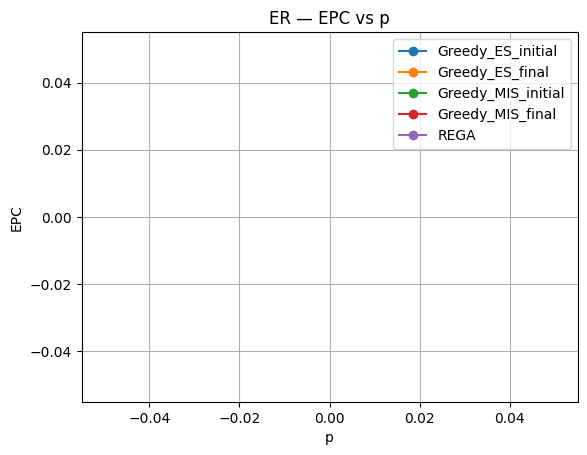

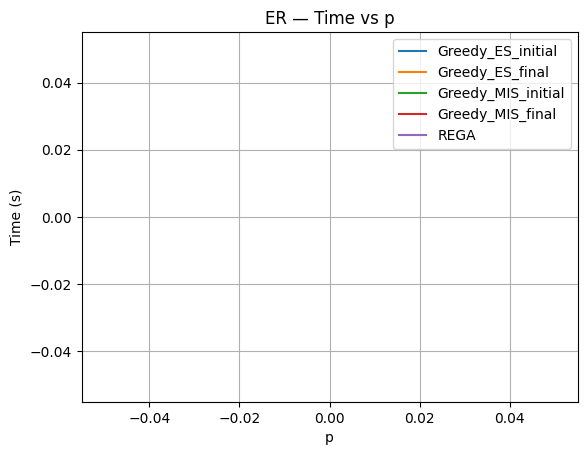

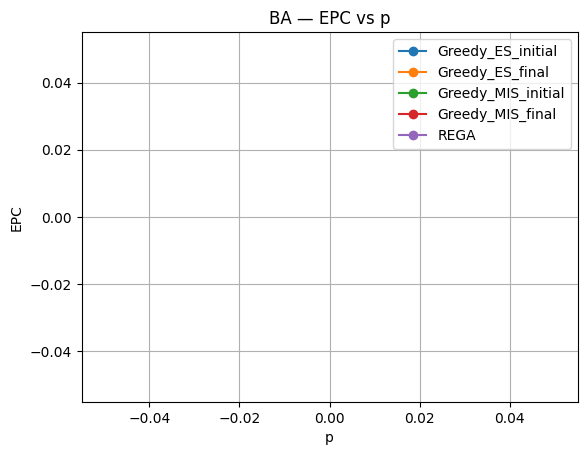

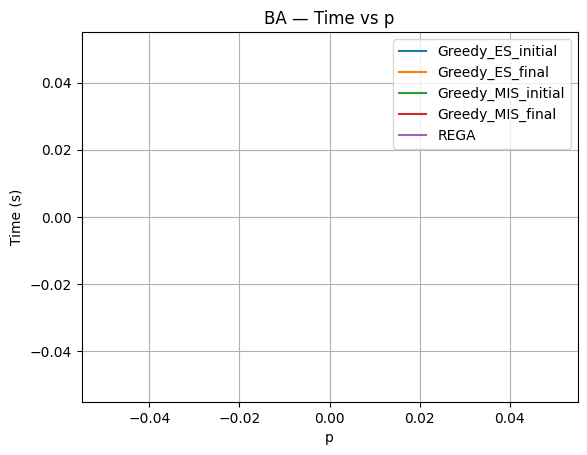

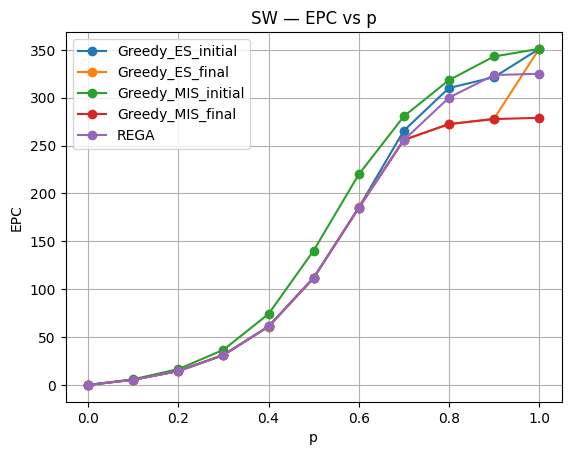

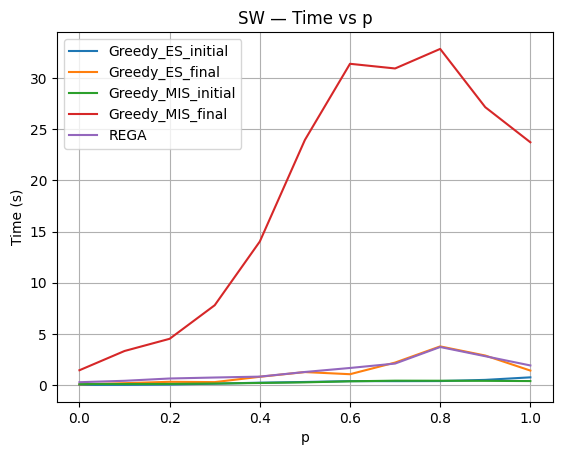

In [40]:
for name in ["ER", "BA", "SW"]:
  plt.figure()
  for algo in df.algo.unique():
    sub=df[(df.model==name)&(df.algo==algo)]
    plt.plot(sub.p, sub.epc, marker='o', label=algo)
  plt.title(f"{name} — EPC vs p")
  plt.xlabel("p"); plt.ylabel("EPC"); plt.grid(True); plt.legend()

  plt.figure()
  for algo in df.algo.unique():
    sub = df[(df.model == name) & (df.algo == algo)]
    plt.plot(sub.p, sub.time, label=algo)
  plt.title(f"{name} — Time vs p")
  plt.xlabel("p"); plt.ylabel("Time (s)"); plt.grid(True); plt.legend()

plt.show()

In [ ]:
SEED = 42
N_SAMPLE = 100_000
# LOCAL_ITER = 5

K = 10
NODES = 100
# nodes 100, edges 200 (Sparse Graphs)
graph_models = {
  'ER': nx.erdos_renyi_graph(NODES, 0.0443, seed=SEED),
  'BA': nx.barabasi_albert_graph(NODES, 2,seed=SEED),
  'SW': nx.watts_strogatz_graph(NODES, 4, 0.3, seed=SEED)
}

for name_model, G in tqdm(
  graph_models.items(), 
  desc="Processing models", 
  total=len(graph_models)):

  records = []
  for p in tqdm(np.arange(0.0, 1.1, 0.1), desc="Processing", total=int(1.1/0.1)):

    def fresh_graph():
      H = G.copy()
      for u, v in H.edges():
        H[u][v]['p'] = p
      return H

    # # greedy ES local
    # t0 = time.perf_counter()

    # t_greedy_es_initial, initial_epc_greedy_es, final_epc_greedy_es = greedy_es_local_opt(
    #   fresh_graph(), K, num_samples=N_SAMPLE,
    #   local_iter=LOCAL_ITER, return_trace=True)
    
    # t_greedy_es_final = time.perf_counter() - t0

    # # greedy MIS local
    # t0 = time.perf_counter()

    # t_greedy_mis_initial, mis_epc_initial, mis_epc_init_std, mis_epc_final, mis_epc_final_std = robust_greedy_mis_optimized(
    #   fresh_graph(), K, num_samples=N_SAMPLE,
    #   trials=10, max_iter=LOCAL_ITER)
    # t_greedy_mis_final = time.perf_counter() - t0
    
    # REGA
    t0 = time.perf_counter()

    rega_D = rega(
      fresh_graph(),
      k=K,
      epc_func=epc_mc_deleted,
      num_samples=100_000,
      use_tqdm=False)
    
    rega_epc = epc_mc_deleted(fresh_graph(), rega_D, N_SAMPLE)
    t_rega = time.perf_counter() - t0

    # print(f"\nGreedy ES init: {initial_epc_greedy_es} vs {final_epc_greedy_es}\n")
    # print(f"\nGreedy MIS init: {mis_epc_initial} vs {mis_epc_final}\n")
    print(f"\n ~~~ name: {name_model} p: {p} --- REGA: {rega_epc} ~~~")

    for algo, t, epc, std in [
      # ('Greedy_ES_initial', t_greedy_es_initial, initial_epc_greedy_es, 0.0),
      # ('Greedy_ES_final', t_greedy_es_final, final_epc_greedy_es, 0.0),

      # ('Greedy_MIS_initial', t_greedy_mis_initial, mis_epc_initial, mis_epc_init_std),
      # ('Greedy_MIS_final', t_greedy_mis_final, mis_epc_final, mis_epc_final_std),

      ('REGA', t_rega, rega_epc, 0)
    ]:
      
      records.append({
        'model': name_model,
        'p': p,
        'algo': algo,
        'time': t,
        'epc': epc,
        'epc_std': std,
      })